# Machine Learning to Predict Brittleness from other Geophysical Logs

## Data: 4 wells from the Appalachian Basin

In [1]:
import os
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor as gbR, GradientBoostingClassifier as gbC, IsolationForest
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.feature_selection import mutual_info_regression

pd.set_option('display.max_columns', None)   #to display all the column information
pd.options.display.max_seq_items = 2000

### Load data

In [2]:
# file_directory = r"C:\Users\tmo0005\Desktop\Thesis work\Thesis work\Well_Data_CSV_Merged"  #for lab computer

file_directory = r"../Thesis work/Thesis work/Well_Data_CSV_Merged"    #for macbook google drive

file_name1 = "Poseidon.csv"
file_name2 = "Boggess.csv"
file_name3 = "Mip3h.csv"
file_name4 = "Whipkey.csv"

file_name = [file_name1, file_name2, file_name3, file_name4]
data = []

for i in file_name:
    file_path = os.path.join(file_directory,i)
    df = pd.read_csv(file_path)
    data.append(df)

In [3]:
data_poseidon = data[0]
data_boggess = data[1]
data_mip3h = data[2]
data_whipkey = data[3]

In [4]:
print("The Poseidon data has {} rows".format(data_poseidon.shape[0]))
print("The Boggess data has {} rows".format(data_boggess.shape[0]))
print("The Mip3h data has {} rows".format(data_mip3h.shape[0]))
print("The Whipkey data has {} rows".format(data_whipkey.shape[0]))

The Poseidon data has 1910 rows
The Boggess data has 2851 rows
The Mip3h data has 2001 rows
The Whipkey data has 1141 rows


In [5]:
data = pd.concat([data_whipkey, 
                  data_boggess,
                  data_mip3h], ignore_index=True)

In [6]:
features =  ['DEPT', 'GR', 'NPHI','RHOZ', 'HCAL', 'DTCO','PEFZ', 'Brittleness_new']   #list of the features names to select
target = 'Brittleness_new'   #name of the output feature
data = data.loc[: ,features]
data[data < 0] = np.nan  #remove negative values
data.dropna(inplace = True)

# Input and Output of the Model

### Data for Classification task

In [7]:
target_cat = 'Brittleness_Ranking'
bins = [0,0.25,1.0]    #group interval for the brittleness classification

In [8]:
def reg_2_cat(data,bins,target,target_cat):
    data2 = data.copy()
    category = pd.cut(data2[target],bins=bins,labels=np.arange(1,len(bins)))
    data2.insert(0,target_cat,category)
    return data2

In [9]:
data2 = reg_2_cat(data, bins, target, target_cat)

In [10]:
data2.dropna(inplace = True)

In [11]:
data2.Brittleness_Ranking.describe()

count     5798
unique       2
top          1
freq      3473
Name: Brittleness_Ranking, dtype: int64

In [12]:
X2 = data2.drop([target,target_cat], axis=1)
y2 = data2.loc[:,[target_cat]]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, test_size=0.3, random_state = 34)

In [13]:
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train2)
# select all rows that are not outliers
mask = yhat != -1
X_train2, y_train2 = X_train2[mask], y_train2[mask]
# summarize the shape of the updated training dataset
print(X_train2.shape, y_train2.shape)

(3652, 7) (3652, 1)


In [14]:
data_poseidon2 = reg_2_cat(data_poseidon, bins, target, target_cat)
data_boggess2 = reg_2_cat(data_boggess, bins, target, target_cat)
data_mip3h2 = reg_2_cat(data_mip3h, bins, target, target_cat)
data_whipkey2 = reg_2_cat(data_whipkey, bins, target, target_cat)

In [15]:
features_temp = features
features_temp.append(target_cat)
df = data_poseidon2.loc[: , features_temp]
df.dropna(inplace=True)
X_blind2 = df.drop([target, target_cat], axis=1)
y_blind2 = df.loc[:,[target_cat]]

Text(0, 0.5, 'frequency')

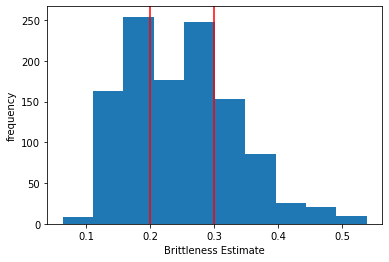

In [16]:
plt.hist(data_whipkey2.Brittleness_new)
plt.axvline(0.2, color = 'r')
plt.axvline(0.3, color = 'r')
plt.xlabel("Brittleness Estimate")
plt.ylabel("frequency")


## Model Building

In [17]:
def modelfit(X_train, X_test, X_blind, y_train, y_test, y_blind, algorithm, hyper_parameters, scaler, classification,printFeatureImportance=True, cv_folds=3):
    """
    function to tune the gradient boosting model and return the optimum
    
    Parameters
    ----------
    X_train : DataFrame
        The input features for the training set
    X_test : DataFrame
        The input features for the testing set
    X_blind : DataFrame
        The input features for the blind set
    y_train : DataFrame 
        The output feature for the training set
    y_test : DataFrame 
        The output feature for the testing set
    y_blind : DataFrame 
        The output feature for the blind set
    algorithm : {'neural','svm','gradientboosting'}
        The Machine Learning model 
    hyper_parameters : dict
        A dictionary of the hyperparameters of the models that will be tuned
    scaler : {'standard','minmax'}
        Scaling technique to employ.
    classification : bool 
        Flag to specify the modeling technique. True for classification and False for regression
    printFeatureImportance : bool
        Flag to specify if to display the feature importance histogram.
    cv_folds : int
        Number of cross-validation folds. default is 3.
    
    Returns
    -------
    model : an object of the trained gradient boosting which can be deployed or saved
    """   
    #step to assign the selected standardaziation 
    if scaler == 'standard':
        scaler = StandardScaler()
    elif scaler == 'minmax':
        scaler =MinMaxScaler()
    else:
        print("invalid scaler: use 'standard' or 'minmax'")
        
    
    #step to assign the selected machine learning algorithm
    if algorithm == 'svm':
        if classification is True:
            algo = SVC(random_state=83)
        else:
            algo = SVR()
        
    elif algorithm == 'neural':
        if classification is True:
            algo = MLPClassifier(random_state=677)
        else:
            algo = MLPRegressor(random_state=134)
    
    elif algorithm == 'gradientboosting':
        if classification is True:
            algo = gbC(random_state=10)
        else:
            algo = gbR(random_state=824)
    else:
        print("invalid scaler: use 'svm' or 'neural' or 'gradientboosting'")
    
     
        
    if classification is True:
        pipe = Pipeline(steps=[('scaler', scaler), ('model', algo)])
        model = GridSearchCV(estimator = pipe,
                             param_grid = hyper_parameters,
                             scoring='accuracy',n_jobs=-1, cv=cv_folds, verbose = 1)
        
        #Fit the model on the data
        model.fit(X_train.values, y_train.values.ravel())

        #Predict training set:
        y_train_pred = model.predict(X_train)

        #Predict testing set:
        y_test_pred = model.predict(X_test)
        
        #Predict blind set
        y_blind_pred = model.predict(X_blind)

        #Print model report:
        print("Model Report")
        print("-------------------------------")
        print("The training accuracy : {0:.4g}".format(metrics.accuracy_score(y_train.values, y_train_pred)))
        print("The testing accuracy is : {0:.4g}".format(metrics.accuracy_score(y_test.values,y_test_pred)))
        print("The blind well accuracy is : {0:.4g}".format(metrics.accuracy_score(y_blind.values,y_blind_pred)))
        print("CV best score : {0:.4g}".format(model.best_score_))
        print("CV best parameter combinations : {}".format(model.best_params_))
        
        if algorithm == 'gradientboosting':
            #Print Feature Importance:
            if printFeatureImportance:
                feat_imp = pd.Series(model.best_estimator_.named_steps.model.feature_importances_, X_train.columns).sort_values(ascending=False)
                feat_imp.plot(kind='barh', title='Feature Importances')
                plt.xlabel('Feature Importance Score')
           
    else:
        pipe = Pipeline(steps=[('scaler', scaler), ('model', algo)])
        model = GridSearchCV(estimator = pipe,
                             param_grid = hyper_parameters,
                             scoring='r2',n_jobs=-1,
                             cv=cv_folds, verbose = 1)
        
        #Fit the model on the data
        model.fit(X_train.values, y_train.values.ravel())

        #Predict training set:
        y_train_pred = model.predict(X_train)

        #Predict testing set:
        y_test_pred = model.predict(X_test)
                        
        #Predict blind set
        y_blind_pred = model.predict(X_blind)

        #Print model report:
        print("Model Report")
        print("-------------------------------")
        print("The training R2 score : {0:.4g}".format(metrics.r2_score(y_train.values, y_train_pred)))
        print("The testing R2 score is : {0:.4g}".format(metrics.r2_score(y_test.values,y_test_pred)))
        print("The blind well R2 score is : {0:.4g}".format(metrics.r2_score(y_blind.values,y_blind_pred)))
        print("CV best score : {0:.4g}".format(model.best_score_))
        print("CV best parameter combinations : {}".format(model.best_params_))
        
        if algorithm == 'gradientboosting':
            #Print Feature Importance:
            if printFeatureImportance:
                feat_imp = pd.Series(model.best_estimator_.named_steps.model.feature_importances_, X_train.columns).sort_values(ascending=False)
                feat_imp.plot(kind='barh', title='Feature Importances')
                plt.xlabel('Feature Importance Score')

    return model.best_estimator_


## Training the Gradient Boosting

In [18]:
#use the documentation of SVR() to understand the parameters
#put new parameters in the grid by using "model__" before the parameter name as below
hyper_parameters =  {"model__min_samples_split" : [3],
                     "model__min_samples_leaf": [1,2,3],
                     "model__max_depth"        : [3, 4, 5,6,7,8,]
                    }

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    8.0s finished


Model Report
-------------------------------
The training accuracy : 1
The testing accuracy is : 0.9546
The blind well accuracy is : 0.8555
CV best score : 0.9463
CV best parameter combinations : {'model__max_depth': 7, 'model__min_samples_leaf': 3, 'model__min_samples_split': 3}


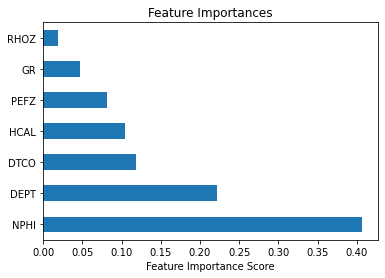

In [19]:
model_gb = modelfit(X_train2, X_test2, X_blind2, y_train2, y_test2, y_blind2, algorithm='gradientboosting', 
             hyper_parameters=hyper_parameters, scaler='standard', 
             classification=True,printFeatureImportance=True, cv_folds=3)

In [20]:
# feat_imp = pd.Series(model_gb.named_steps.model.feature_importances_, X_train.columns).sort_values(ascending=False)
# feat_imp.plot(kind='barh', title='Feature Importances')
# plt.xlabel('Feature Importance Score')
# # plt.savefig(r'./Images/{}.png'.format('gb_feature_importance'), dpi=300)

## Training the SVM

In [21]:
#use the documentation of SVR() to understand the parameters
#put new parameters in the grid by using "model__" before the parameter name as below
hyper_parameters = {
                    'model__C': np.logspace(0,2,2)}

In [22]:
model_svm = modelfit(X_train2, X_test2, X_blind2, y_train2, y_test2, y_blind2, algorithm='svm', 
         hyper_parameters=hyper_parameters, scaler='standard', 
         classification=True,printFeatureImportance=False, cv_folds=3)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished


Model Report
-------------------------------
The training accuracy : 0.9515
The testing accuracy is : 0.9339
The blind well accuracy is : 0.7832
CV best score : 0.9252
CV best parameter combinations : {'model__C': 100.0}


## Training the Neural Network

In [23]:
#use the documentation of MLPClassifier() to understand the parameters
#put new parameters in the grid by using "model__" before the parameter name as below
hyper_parameters =  {'model__hidden_layer_sizes': [(10,10,),(19,19,),(20,),(20,20,)],
                     'model__tol': [0.0001,0.00001,0.001],
                    'model__solver': ['lbfgs'],
                    'model__max_iter': [1000]}

In [24]:
model_nn = modelfit(X_train2, X_test2, X_blind2, y_train2, y_test2, y_blind2, algorithm='neural', 
         hyper_parameters=hyper_parameters, scaler='minmax', 
         classification=True,printFeatureImportance=True, cv_folds=3)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    7.6s finished


Model Report
-------------------------------
The training accuracy : 0.9389
The testing accuracy is : 0.9276
The blind well accuracy is : 0.8058
CV best score : 0.9294
CV best parameter combinations : {'model__hidden_layer_sizes': (19, 19), 'model__max_iter': 1000, 'model__solver': 'lbfgs', 'model__tol': 0.0001}


/Users/tobiore/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Visualizing the Result

In [25]:
#create folder to save images
if os.path.exists(r'./Images'):
    pass
else:
    os.mkdir(r'./Images')

In [31]:
def plot_logs(data, well_name, model_gb, model_svm, model_nn, formation, classification):
    """
    function to plot the log data and the predictions
    
    Parameters
    ----------
    data : DataFrame
        The well data to be plotted
    well_name : str
        The name of the well being plotted
    model:
        The trained model used for the prediction
    formation : dict
        The formation tops ( names as keys and depth interval as the item in a list)
    
    Returns
    -------
    A plot of the well logs
    """         
    data = data.loc[: , ['DEPT', 'GR', 'NPHI','RHOZ', 'HCAL', 'DTCO','PEFZ', 'Brittleness_new', 'Brittleness_Ranking']].dropna()
    pred = model_gb.predict(data.drop(['Brittleness_new', 'Brittleness_Ranking'], axis=1))
    data['Brittleness_predict_GB'] = pred  
    
    pred = model_svm.predict(data.drop(['Brittleness_new', 'Brittleness_Ranking','Brittleness_predict_GB'], axis=1))
    data['Brittleness_predict_SVM'] = pred 
    
    pred = model_nn.predict(data.drop(['Brittleness_new', 'Brittleness_Ranking','Brittleness_predict_GB', 'Brittleness_predict_SVM'], axis=1))
    data['Brittleness_predict_NN'] = pred
    
    
    #assigning the logs to variable names to make the code cleaner and easier to read
    MD = data.DEPT
    GR = data.GR
    RHOB = data.RHOZ
    NPHI = data.NPHI
    DT= data.DTCO
    PEFZ = data.PEFZ
    BA = data.Brittleness_new

    #creating the figure
    if classification is True:
        fig, ax = plt.subplots(nrows=1, ncols=9,figsize=(15,10), sharey=True, gridspec_kw={'width_ratios': [3,3,3,3,2,2,2,2,1]})
    else:
        fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(12,10), sharey=True, gridspec_kw={'width_ratios': [3,3,3,3,1]})
        
#     fig.suptitle("{} Well Log Display".format(well_name), fontsize=25)
    fig.subplots_adjust(top=0.85, wspace=0.05)

    ax[0].set_ylim(formation['Upper Marcellus'][0],formation['Lower Marcellus'][1])  #display only a depth range
    ax[0].invert_yaxis()
    ax[0].set_ylabel('MD (M)',fontsize=20)
    ax[0].yaxis.grid(True)
    ax[0].get_xaxis().set_visible(False) #removing the x-axis label at the bottom of the fig

    ##Track 1
    ##Gamma_ray and PEF 
    ax_GR = ax[0].twiny()  #share the depth axis
    ax_GR.set_xlim(0,270)
    ax_GR.plot(GR,MD, color='black')
    ax_GR.set_xlabel('GR (API)',color='black')
    ax_GR.tick_params('x',colors='black')  ##change the color of the x-axis tick label
    ax[0].get_xaxis().set_visible(False)
    ax[0].yaxis.grid(True)
    ax_GR.grid(True,alpha=0.5)

    #variable colorfill
    GR_range = abs(GR.min() - GR.max())
    cmap = plt.get_cmap('nipy_spectral')   #color map
    color_index = np.arange(GR.min(), GR.max(), GR_range / 20)

    #loop through each value in the color_index
    for index in sorted(color_index):
        index_value = (index - GR.min())/GR_range
        color = cmap(index_value) #obtain colour for color index value
        ax_GR.fill_betweenx(MD, 0 , GR, where = GR >= index,  color = color)


    ax_PEFZ = ax[0].twiny()
    ax_PEFZ.plot(PEFZ,MD, color='red')
    ax_PEFZ.set_xlabel('PEFZ',color='red')
    ax_PEFZ.tick_params('x',colors='red')  ##change the color of the x-axis tick label
    ax_PEFZ.spines['top'].set_position(('outward',40)) ##move the x-axis up
    ax_PEFZ.spines["top"].set_edgecolor("red")

    #Track 2
    ##NPHI and RHOB
    ax_NPHI = ax[1].twiny()
    ax_NPHI.set_xlim(-0.1,0.4)
    ax_NPHI.invert_xaxis()
    ax_NPHI.plot(NPHI, MD, label='NPHI[%]', color='green') 
    ax_NPHI.spines['top'].set_position(('outward',0))
    ax_NPHI.set_xlabel('NPHI[%]', color='green')    
    ax_NPHI.tick_params(axis='x', colors='green')
    ax_NPHI.spines["top"].set_edgecolor("green")

    ax_RHOB = ax[1].twiny()
    ax_RHOB.set_xlim(1.95,2.95)
    ax_RHOB.invert_xaxis()
    ax_RHOB.plot(RHOB, MD,label='RHOB[g/cc]', color='red') 
    ax_RHOB.spines['top'].set_position(('outward',40))
    ax_RHOB.set_xlabel('RHOB[g/cc]',color='red')
    ax_RHOB.tick_params(axis='x', colors='red')
    ax_RHOB.spines["top"].set_edgecolor('red')

    ax[1].get_xaxis().set_visible(False)
    ax[1].yaxis.grid(True)
    ax_RHOB.grid(True,alpha=0.5)
    ax[1].axis('off')

    # #color fill
    # x = np.array(ax_RHOB.get_xlim())
    # z = np.array(ax_NPHI.get_xlim())

    # nz=((NPHI-np.max(z))/(np.min(z)-np.max(z)))*(np.max(x)-np.min(x))+np.min(x)

    # ax_RHOB.fill_betweenx(MD, RHOB, nz, where=RHOB>=nz, interpolate=True, color='green')
    # ax_RHOB.fill_betweenx(MD, RHOB, nz, where=RHOB<=nz, interpolate=True, color='yellow')

    #Track 3
    ##Sonic 
    ax_DT = ax[2].twiny()
    ax_DT.grid(True)
    ax_DT.set_xlim(100,50)
    ax_DT.spines['top'].set_position(('outward',0))
    ax_DT.plot(DT, MD, label='DT[us/ft]', color='blue')
    ax_DT.set_xlabel('DT[us/ft]', color='blue')    
    ax_DT.tick_params(axis='x', colors='blue')
    ax_DT.spines["top"].set_edgecolor("blue")

    ax[2].get_xaxis().set_visible(False)
    ax[2].yaxis.grid(True)
    ax_DT.grid(True,alpha=0.5)
    ax[2].axis('off')

    #Track 4
    ##Brittleness
    ax_BA = ax[3].twiny()
    ax_BA.grid(True)
    ax_BA.set_xlim(0,1)
    ax_BA.spines['top'].set_position(('outward',0))
    ax_BA.plot(BA, MD, label='BRITTLENESS ESTIMATE', color='black')
    ax_BA.set_xlabel('BRITTLENESS ESTIMATE', color='black')    
    ax_BA.tick_params(axis='x', colors='black')
    ax[3].get_xaxis().set_visible(False)
    
    
    #variable colorfill
    BA_range = abs(BA.min() - BA.max())
    cmap = plt.get_cmap('nipy_spectral')   #color map
    color_index = np.arange(BA.min(), BA.max(), BA_range / 20)
    
    #loop through each value in the color_index
    for index in sorted(color_index):
        index_value = (index - BA.min())/BA_range
        color = cmap(index_value) #obtain colour for color index value
        ax_BA.fill_betweenx(MD, 0 , BA, where = BA >= index,  color = color)


    ##Ploting the predicted data
    ###work on this for generalization
    if classification is True:
        cmap_facies = colors.ListedColormap(['orange','brown', 'green'], 'indexed')

        ax_BA_class = ax[4].twiny()
        cluster=np.repeat(np.expand_dims(data['Brittleness_Ranking'].values,1), 5, 1)
        im=ax_BA_class.imshow(cluster, interpolation='none', cmap=cmap_facies, aspect='auto',
                        vmin=data['Brittleness_Ranking'].min(),vmax=data['Brittleness_Ranking'].max(), 
                     extent=[0,5, data.DEPT.max(), data.DEPT.min()])
        ax_BA_class.set_xlabel("ACTUAL")

        ax_BA_class_pred1 = ax[5].twiny()
        cluster=np.repeat(np.expand_dims(data['Brittleness_predict_GB'].values,1), 5, 1)
        im=ax_BA_class_pred1.imshow(cluster, interpolation='none', cmap=cmap_facies, aspect='auto',
                        vmin=data['Brittleness_predict_GB'].min(),vmax=data['Brittleness_predict_GB'].max(), 
                     extent=[0,5, data.DEPT.max(), data.DEPT.min()])
        ax_BA_class_pred1.set_xlabel("GB")
        
        ax_BA_class_pred2 = ax[6].twiny()
        cluster=np.repeat(np.expand_dims(data['Brittleness_predict_SVM'].values,1), 5, 1)
        im=ax_BA_class_pred2.imshow(cluster, interpolation='none', cmap=cmap_facies, aspect='auto',
                        vmin=data['Brittleness_predict_SVM'].min(),vmax=data['Brittleness_predict_SVM'].max(), 
                     extent=[0,5, data.DEPT.max(), data.DEPT.min()])
        ax_BA_class_pred2.set_xlabel("SVM")
        
        ax_BA_class_pred3 = ax[7].twiny()
        cluster=np.repeat(np.expand_dims(data['Brittleness_predict_NN'].values,1), 5, 1)
        im=ax_BA_class_pred3.imshow(cluster, interpolation='none', cmap=cmap_facies, aspect='auto',
                        vmin=data['Brittleness_predict_NN'].min(),vmax=data['Brittleness_predict_NN'].max(), 
                     extent=[0,5, data.DEPT.max(), data.DEPT.min()])
        ax_BA_class_pred3.set_xlabel("NN")
        
        
        ax[4].get_xaxis().set_visible(False)
        ax[5].get_xaxis().set_visible(False)
        ax[6].get_xaxis().set_visible(False)
        ax[7].get_xaxis().set_visible(False)

    
    else:
        ax_pred = ax[3].twiny()
        df = data.loc[: , features].dropna()
        pred = model.predict(df.drop([target], axis=1))
        df['Brittleness_predict'] = pred  
        ax_BA.plot(df.Brittleness_predict, df.DEPT, color='red', linestyle='--')

        ax_pred.spines['top'].set_position(('outward',40))
        ax_pred.set_xlabel('BRITTLENESS PREDICTED',color='red')
        ax_pred.tick_params(axis='x', colors='red')
        ax_pred.spines["top"].set_edgecolor('red')

        
        ax[3].get_xaxis().set_visible(False)
        ax[3].yaxis.grid(True)
        ax[3].axis('off')
        ax_BA.grid(True,alpha=0.5)


    #formation top
    ax_top = ax[-1]
    ax[-1].axis('off')

    formation_midpoints = []
    for key, value in formation.items():
        #Calculate mid point of the formation
        formation_midpoints.append(value[0] + (value[1]-value[0])/2)

    zone_colours = ["red", "blue", "green"]

    for ax in [ax_GR, ax_NPHI, ax_DT, ax_BA, ax_top]:
        # loop through the formations dictionary and zone colours
        for depth, colour in zip(formation.values(), zone_colours):
            # use the depths and colours to shade across the subplots
            ax.axhspan(depth[0], depth[1], color=colour, alpha=0.1)

    for label, formation_mid in zip(formation.keys(), 
                                        formation_midpoints):
        ax_top.text(0.5, formation_mid, label, rotation=90,
                    verticalalignment='center', horizontalalignment='center', fontweight='bold',
                    fontsize='large')
        
#     fig.savefig(r'./Images/{}_strategy3.png'.format(well_name), dpi=600)

In [27]:
# formation = {'Upper Marcellus': [7453,7476],
#              'Middle Marcellus': [7476,7517],
#             'Lower Marcellus': [7517,7555]}

# plot_logs(data_mip3h2, "MIP3H", model_gb, model_svm, model_nn, formation, classification = True)

In [28]:
# formation_pos = {'Upper Marcellus': [7883,7961],
#              'Middle Marcellus': [7961,8015],
#             'Lower Marcellus': [8015,8052]}

# plot_logs(data_poseidon2,"Poseidon", model_gb, model_svm, model_nn, formation_pos, classification = True)

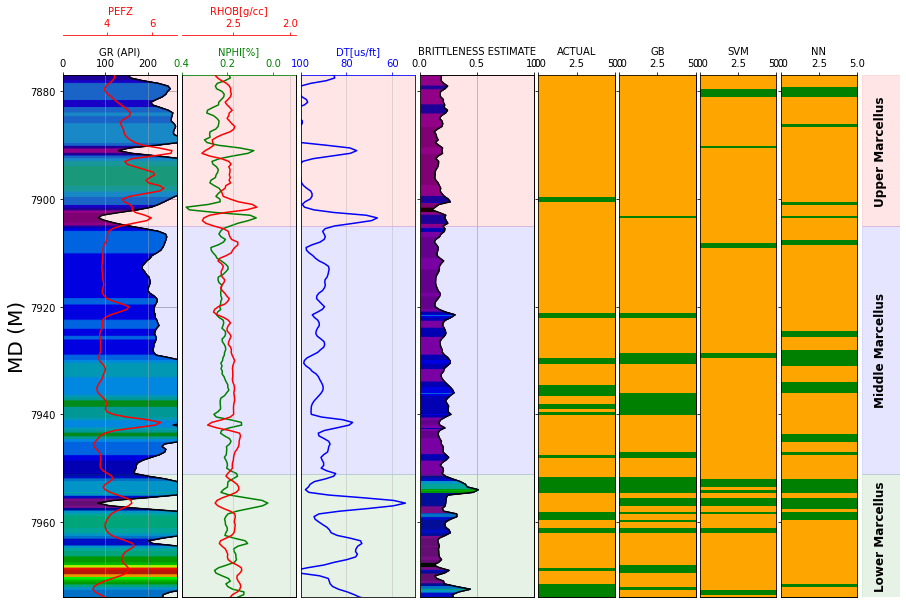

In [32]:
formation_bog = {'Upper Marcellus': [7877,7905],
             'Middle Marcellus': [7905, 7951],
            'Lower Marcellus': [7951,7974]}
plot_logs(data_boggess2, "Boggess", model_gb, model_svm, model_nn, formation_bog, classification = True)

In [30]:
# formation_whip = {'Upper Marcellus': [7736, 7785],
#              'Middle Marcellus': [7785, 7811],
#             'Lower Marcellus': [7811, 7835]}
# plot_logs(data_whipkey2, "Whipkey", model_gb, model_svm, model_nn, formation_whip, classification = True)